# Galaxy10 + CNN, with preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
BASE = Path().resolve().parent
print(f'BASE: {BASE}')

import torch
torch.manual_seed(0)

IS_MPS_AVAILABLE = torch.backends.mps.is_available() and torch.backends.mps.is_built()
print(f'Is mps avaliable? : {IS_MPS_AVAILABLE}')

import h5py
from tqdm import tqdm

from sklearn.model_selection import train_test_split

BASE: /Users/zheng/Documents/Study/SDSSGalCat
Is mps avaliable? : True


In [2]:
# load data
# data ref: https://astronn.readthedocs.io/en/stable/galaxy10sdss.html

with h5py.File(BASE / 'data/Galaxy10.h5', 'r') as f:
    images = f['images'][:]
    labels = f['ans'][:]

print(f'images.shape: {images.shape}, labels.shape: {labels.shape}')
assert images.shape[0] == labels.shape[0]

images.shape: (21785, 69, 69, 3), labels.shape: (21785,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


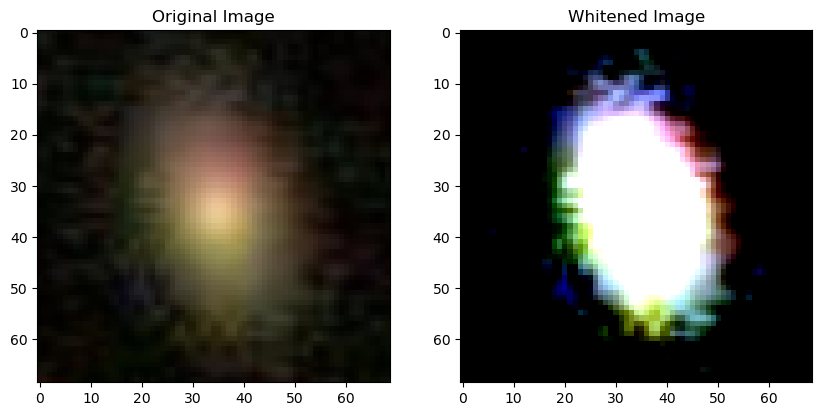

In [3]:
# whiting the image
img_mean = np.mean(images, axis=(1, 2), keepdims=True)
img_std = np.std(images, axis=(1, 2), keepdims=True)
images_white = (images - img_mean) / img_std

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(images[0], cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(images_white[0], cmap='gray')
ax[1].set_title('Whitened Image')
plt.show()
plt.close()

images.shape: (87140, 69, 69, 3), labels.shape: (87140,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: (174280, 69, 69, 3), labels.shape: (174280,)


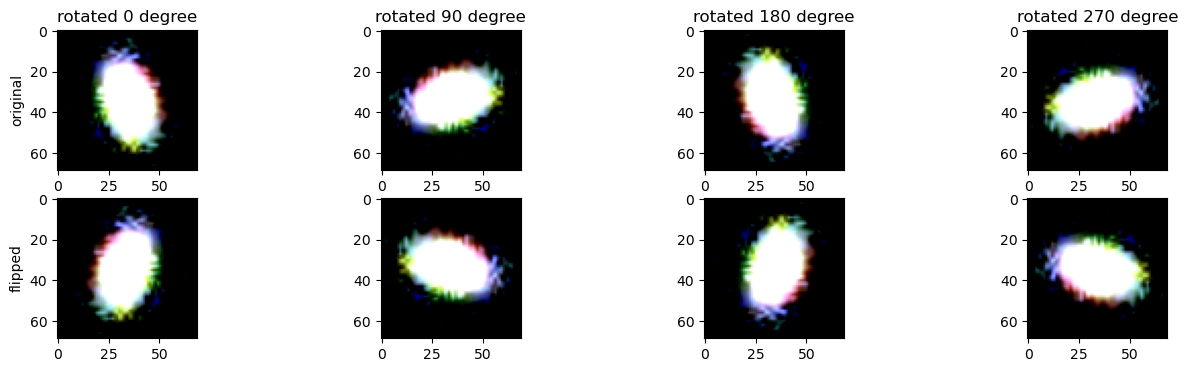

In [4]:
# enlarge the dataset: rotating the images by 90, 180, 270 degrees
images_enlarged = np.concatenate([images_white, np.rot90(images_white, k=1, axes=(1, 2)), np.rot90(images_white, k=2, axes=(1, 2)), np.rot90(images_white, k=3, axes=(1, 2))])
labels_enlarged = np.concatenate([labels, labels, labels, labels])
print(f'images.shape: {images_enlarged.shape}, labels.shape: {labels_enlarged.shape}')

# flip the images horizontally
images_flipped = np.flip(images_enlarged, axis=2)
images_enlarged_flipped = np.concatenate([images_enlarged, images_flipped])
labels_enlarged_flipped = np.concatenate([labels_enlarged, labels_enlarged])
print(f'images.shape: {images_enlarged_flipped.shape}, labels.shape: {labels_enlarged_flipped.shape}')

fig, axs = plt.subplots(2, 4, figsize=(16, 4))
# for i, ax in enumerate(axs):
#     ax.imshow(images_enlarged[i*images.shape[0]], cmap='gray')
#     ax.set_title(f'rotated {i*90} degree')
for i, ax in enumerate(axs[0]):
    ax.imshow(images_enlarged[i*images.shape[0]], cmap='gray')
    ax.set_title(f'rotated {i*90} degree')
    if i == 0:
        ax.set_ylabel('original')
for i, ax in enumerate(axs[1]):
    ax.imshow(images_flipped[i*images.shape[0]], cmap='gray')
    if i == 0:
        ax.set_ylabel('flipped')
plt.show()
plt.close()

del images_white, images_enlarged, labels_enlarged, images_flipped

images.shape: (18136, 69, 69, 3), labels.shape: (18136,)


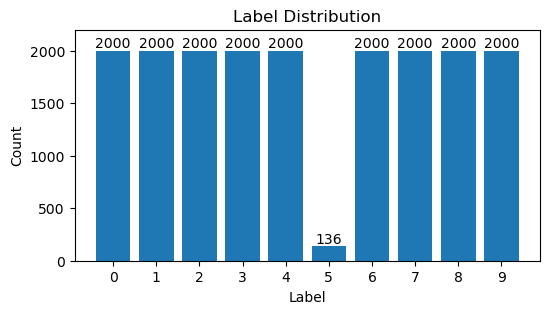

In [5]:
# balance the sample: select at most 1000 samples for each class
np.random.seed(0)
n_samples = 2000
images_balanced = []
labels_balanced = []
for i in range(10):
    if n_samples > np.sum(labels_enlarged_flipped == i):
        images_balanced.append(images_enlarged_flipped[labels_enlarged_flipped == i])
        labels_balanced.append(labels_enlarged_flipped[labels_enlarged_flipped == i])
        continue
    idx = np.where(labels_enlarged_flipped == i)[0]
    idx = np.random.choice(idx, n_samples, replace=False)
    images_balanced.append(images_enlarged_flipped[idx])
    labels_balanced.append(labels_enlarged_flipped[idx])
images_balanced = np.concatenate(images_balanced)
labels_balanced = np.concatenate(labels_balanced)
print(f'images.shape: {images_balanced.shape}, labels.shape: {labels_balanced.shape}')

# show distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.bar(range(10), np.histogram(labels_balanced, bins=10)[0])
ax.set_title('Label Distribution')
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_xticks(range(10))
for i in range(10):
    ax.text(i, np.sum(labels_balanced == i), f'{np.sum(labels_balanced == i)}', ha='center', va='bottom')
ax.set_ylim(0, 1.1*np.max(np.histogram(labels_balanced, bins=10)[0]))
plt.show()
plt.close()

In [6]:
# split the data, 90% for training and 10% for testing
# make sure that there are equal number of samples for each class in the training and testing set
X_train, X_test, y_train, y_test = train_test_split(images_balanced, labels_balanced, test_size=0.1, stratify=labels_balanced, random_state=0)
print(f'X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}')

del images_enlarged_flipped, labels_enlarged_flipped

X_train.shape: (16322, 69, 69, 3), y_train.shape: (16322,)
X_test.shape: (1814, 69, 69, 3), y_test.shape: (1814,)


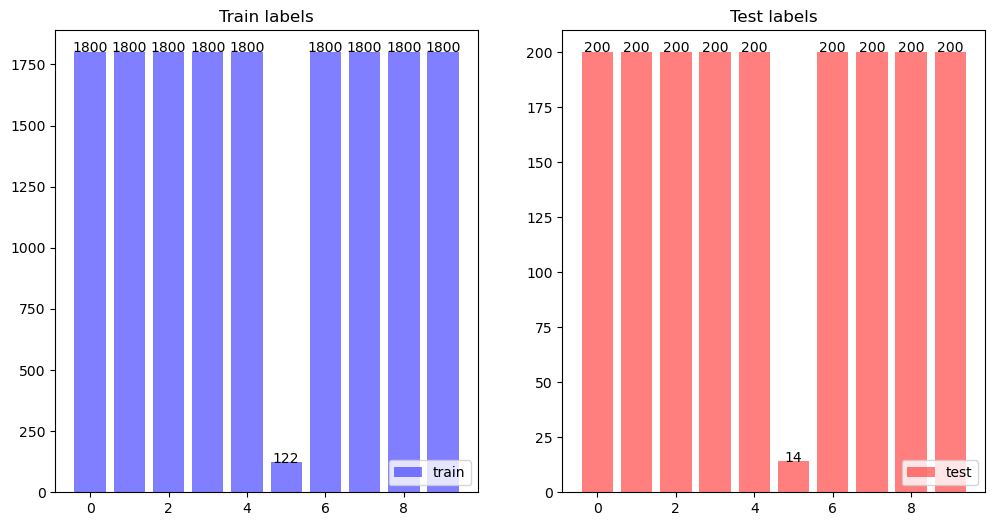

In [7]:
# visualize the splited data
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(range(10), np.histogram(y_train, bins=10)[0], color='blue', alpha=0.5, label='train')
for i in range(10):
    ax[0].text(i, y_train.tolist().count(i), str(y_train.tolist().count(i)), color='black', ha='center')
ax[0].set_title('Train labels')
ax[0].legend(loc='lower right')

ax[1].bar(range(10), np.histogram(y_test, bins=10)[0], color='red', alpha=0.5, label='test')
for i in range(10):
    ax[1].text(i, y_test.tolist().count(i), str(y_test.tolist().count(i)), color='black', ha='center')
ax[1].set_title('Test labels')
ax[1].legend(loc='lower right')

plt.show()
plt.close()

In [8]:
# built a torch CNN 
# ref: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # input is a 3 channel image with 69x69 pixels, output is 10 classes
        # cov calculator: http://www.sqflash.com/cal.html

        self.conv1 = torch.nn.Conv2d(3, 6, 5)   # out 65*65, 32*32 after pool
        self.conv2 = torch.nn.Conv2d(6, 16, 5)  # out 28*28, 14*14 after pool

        self.pool = torch.nn.MaxPool2d(2, 2)

        self.fc1 = torch.nn.Linear(16 * 14 * 14, 512)   # 3136 -> 512
        self.fc2 = torch.nn.Linear(512, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_CNN = CNN()

In [9]:
# define the optimizer and loss function
crit = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(net_CNN.parameters(), lr=0.001, momentum=0.9)

Epoch 1/128: 32it [00:08,  3.75it/s]                        


Epoch 1 loss: 2.2995245061424954


Epoch 2/128: 32it [00:08,  3.75it/s]                        


Epoch 2 loss: 2.2919553764426466


Epoch 3/128: 32it [00:08,  3.78it/s]                        


Epoch 3 loss: 2.281380169941739


Epoch 4/128: 32it [00:08,  3.75it/s]                        


Epoch 4 loss: 2.2646032500947726


Epoch 5/128: 32it [00:08,  3.76it/s]                        


Epoch 5 loss: 2.2373099900273594


Epoch 6/128: 32it [00:08,  3.76it/s]                        


Epoch 6 loss: 2.203649942729713


Epoch 7/128: 32it [00:08,  3.76it/s]                        


Epoch 7 loss: 2.162580955906426


Epoch 8/128: 32it [00:08,  3.76it/s]                        


Epoch 8 loss: 2.085155620278133


Epoch 9/128: 32it [00:08,  3.75it/s]                        


Epoch 9 loss: 1.9327388913472805


Epoch 10/128: 32it [00:08,  3.76it/s]                        


Epoch 10 loss: 1.7563010478571865


Epoch 11/128: 32it [00:08,  3.74it/s]                        


Epoch 11 loss: 1.63183103883227


Epoch 12/128: 32it [00:08,  3.75it/s]                        


Epoch 12 loss: 1.545378894523113


Epoch 13/128: 32it [00:08,  3.75it/s]                        


Epoch 13 loss: 1.4794211829940036


Epoch 14/128: 32it [00:08,  3.75it/s]                        


Epoch 14 loss: 1.4418197686057832


Epoch 15/128: 32it [00:08,  3.75it/s]                        


Epoch 15 loss: 1.4063863063644448


Epoch 16/128: 32it [00:08,  3.74it/s]                        


Epoch 16 loss: 1.3833591501848062


Epoch 17/128: 32it [00:08,  3.75it/s]                        


Epoch 17 loss: 1.3638284797981635


Epoch 18/128: 32it [00:08,  3.74it/s]                        


Epoch 18 loss: 1.3512609514765348


Epoch 19/128: 32it [00:08,  3.76it/s]                        


Epoch 19 loss: 1.3320948803283146


Epoch 20/128: 32it [00:08,  3.74it/s]                        


Epoch 20 loss: 1.3108792103413434


Epoch 21/128: 32it [00:08,  3.75it/s]                        


Epoch 21 loss: 1.289853466563534


Epoch 22/128: 32it [00:08,  3.75it/s]                        


Epoch 22 loss: 1.2746292561121013


Epoch 23/128: 32it [00:08,  3.76it/s]                        


Epoch 23 loss: 1.257918367314581


Epoch 24/128: 32it [00:08,  3.74it/s]                        


Epoch 24 loss: 1.2338588412172318


Epoch 25/128: 32it [00:08,  3.73it/s]                        


Epoch 25 loss: 1.2222993390523047


Epoch 26/128: 32it [00:08,  3.74it/s]                        


Epoch 26 loss: 1.2066981779887767


Epoch 27/128: 32it [00:08,  3.75it/s]                        


Epoch 27 loss: 1.1960430895489025


Epoch 28/128: 32it [00:08,  3.75it/s]                        


Epoch 28 loss: 1.1805369962943038


Epoch 29/128: 32it [00:08,  3.74it/s]                        


Epoch 29 loss: 1.161133313585096


Epoch 30/128: 32it [00:08,  3.74it/s]                        


Epoch 30 loss: 1.1500954821389937


Epoch 31/128: 32it [00:08,  3.74it/s]                        


Epoch 31 loss: 1.1282002958885056


Epoch 32/128: 32it [00:08,  3.73it/s]                        


Epoch 32 loss: 1.1305002203876957


Epoch 33/128: 32it [00:08,  3.73it/s]                        


Epoch 33 loss: 1.095819257080168


Epoch 34/128: 32it [00:08,  3.73it/s]                        


Epoch 34 loss: 1.0968112559926786


Epoch 35/128: 32it [00:08,  3.71it/s]                        


Epoch 35 loss: 1.0791897422585792


Epoch 36/128: 32it [00:08,  3.71it/s]                        


Epoch 36 loss: 1.068165724307587


Epoch 37/128: 32it [00:08,  3.70it/s]                        


Epoch 37 loss: 1.0461139470948673


Epoch 38/128: 32it [00:08,  3.70it/s]                        


Epoch 38 loss: 1.040395715426265


Epoch 39/128: 32it [00:08,  3.70it/s]                        


Epoch 39 loss: 1.0134067916355944


Epoch 40/128: 32it [00:08,  3.70it/s]                        


Epoch 40 loss: 1.018628021677749


Epoch 41/128: 32it [00:08,  3.72it/s]                        


Epoch 41 loss: 0.9916790238987975


Epoch 42/128: 32it [00:08,  3.71it/s]                        


Epoch 42 loss: 0.995910913771003


Epoch 43/128: 32it [00:08,  3.71it/s]                        


Epoch 43 loss: 0.9773986016165873


Epoch 44/128: 32it [00:08,  3.71it/s]                        


Epoch 44 loss: 0.9547312918458407


Epoch 45/128: 32it [00:08,  3.71it/s]                        


Epoch 45 loss: 0.9460020678809659


Epoch 46/128: 32it [00:08,  3.74it/s]                        


Epoch 46 loss: 0.9361219542851242


Epoch 47/128: 32it [00:08,  3.73it/s]                        


Epoch 47 loss: 0.9217135066305974


Epoch 48/128: 32it [00:08,  3.75it/s]                        


Epoch 48 loss: 0.9110854225640145


Epoch 49/128: 32it [00:08,  3.73it/s]                        


Epoch 49 loss: 0.9070262911272697


Epoch 50/128: 32it [00:08,  3.71it/s]                        


Epoch 50 loss: 0.8950855772572104


Epoch 51/128: 32it [00:08,  3.75it/s]                        


Epoch 51 loss: 0.8892742316376095


Epoch 52/128: 32it [00:08,  3.73it/s]                        


Epoch 52 loss: 0.8741492696901613


Epoch 53/128: 32it [00:08,  3.74it/s]                        


Epoch 53 loss: 0.8610272981886506


Epoch 54/128: 32it [00:08,  3.73it/s]                        


Epoch 54 loss: 0.8546423671906113


Epoch 55/128: 32it [00:08,  3.75it/s]                        


Epoch 55 loss: 0.8448233037087836


Epoch 56/128: 32it [00:08,  3.73it/s]                        


Epoch 56 loss: 0.8393593091559226


Epoch 57/128: 32it [00:08,  3.74it/s]                        


Epoch 57 loss: 0.8291084318531449


Epoch 58/128: 32it [00:08,  3.75it/s]                        


Epoch 58 loss: 0.8184984036775039


Epoch 59/128: 32it [00:08,  3.75it/s]                        


Epoch 59 loss: 0.8111968440703354


Epoch 60/128: 32it [00:08,  3.71it/s]                        


Epoch 60 loss: 0.8099314452766013


Epoch 61/128: 32it [00:08,  3.63it/s]                        


Epoch 61 loss: 0.8416492960906149


Epoch 62/128: 32it [00:08,  3.58it/s]                        


Epoch 62 loss: 0.8357646256418676


Epoch 63/128: 32it [00:09,  3.54it/s]                        


Epoch 63 loss: 0.8142353399552751


Epoch 64/128: 32it [00:09,  3.48it/s]                        


Epoch 64 loss: 0.7895860927915065


Epoch 65/128: 32it [00:09,  3.47it/s]                        


Epoch 65 loss: 0.7924099111072048


Epoch 66/128: 32it [00:09,  3.43it/s]                        


Epoch 66 loss: 0.7839608498026294


Epoch 67/128: 32it [00:09,  3.45it/s]                        


Epoch 67 loss: 0.7882232946473701


Epoch 68/128: 32it [00:09,  3.45it/s]                        


Epoch 68 loss: 0.7566769532955185


Epoch 69/128: 32it [00:09,  3.47it/s]                        


Epoch 69 loss: 0.7470242294986492


Epoch 70/128: 32it [00:09,  3.47it/s]                        


Epoch 70 loss: 0.7324857203461729


Epoch 71/128: 32it [00:09,  3.53it/s]                        


Epoch 71 loss: 0.7267754761235794


Epoch 72/128: 32it [00:08,  3.56it/s]                        


Epoch 72 loss: 0.7117384994837777


Epoch 73/128: 32it [00:08,  3.62it/s]                        


Epoch 73 loss: 0.7048004228918886


Epoch 74/128: 32it [00:08,  3.67it/s]                        


Epoch 74 loss: 0.6957679975706198


Epoch 75/128: 32it [00:08,  3.67it/s]                        


Epoch 75 loss: 0.6867736752835752


Epoch 76/128: 32it [00:08,  3.71it/s]                        


Epoch 76 loss: 0.678394818244619


Epoch 77/128: 32it [00:08,  3.71it/s]                        


Epoch 77 loss: 0.6702946916600533


Epoch 78/128: 32it [00:08,  3.73it/s]                        


Epoch 78 loss: 0.6624881635473546


Epoch 79/128: 32it [00:08,  3.72it/s]                        


Epoch 79 loss: 0.6567547740545975


Epoch 80/128: 32it [00:08,  3.76it/s]                        


Epoch 80 loss: 0.6501906415642279


Epoch 81/128: 32it [00:08,  3.73it/s]                        


Epoch 81 loss: 0.6434494203657017


Epoch 82/128: 32it [00:08,  3.74it/s]                        


Epoch 82 loss: 0.6376764358017553


Epoch 83/128: 32it [00:08,  3.75it/s]                        


Epoch 83 loss: 0.6323857736885511


Epoch 84/128: 32it [00:08,  3.72it/s]                        


Epoch 84 loss: 0.6320707781351952


Epoch 85/128: 32it [00:08,  3.73it/s]                        


Epoch 85 loss: 0.6341157438065284


Epoch 86/128: 32it [00:08,  3.75it/s]                        


Epoch 86 loss: 0.6205356085129542


Epoch 87/128: 32it [00:08,  3.74it/s]                        


Epoch 87 loss: 0.606628034676046


Epoch 88/128: 32it [00:08,  3.74it/s]                        


Epoch 88 loss: 0.5947593573977032


Epoch 89/128: 32it [00:08,  3.74it/s]                        


Epoch 89 loss: 0.5851211669383396


Epoch 90/128: 32it [00:08,  3.74it/s]                        


Epoch 90 loss: 0.5787009206593526


Epoch 91/128: 32it [00:08,  3.72it/s]                        


Epoch 91 loss: 0.5726326324384362


Epoch 92/128: 32it [00:08,  3.75it/s]                        


Epoch 92 loss: 0.5657399087220397


Epoch 93/128: 32it [00:08,  3.75it/s]                        


Epoch 93 loss: 0.5611585465851784


Epoch 94/128: 32it [00:08,  3.76it/s]                        


Epoch 94 loss: 0.560784252845924


Epoch 95/128: 32it [00:08,  3.76it/s]                        


Epoch 95 loss: 0.5689106003908883


Epoch 96/128: 32it [00:08,  3.72it/s]                        


Epoch 96 loss: 0.617433250454357


Epoch 97/128: 32it [00:08,  3.74it/s]                        


Epoch 97 loss: 0.575165277309766


Epoch 98/128: 32it [00:08,  3.73it/s]                        


Epoch 98 loss: 0.5807374473471747


Epoch 99/128: 32it [00:08,  3.74it/s]                        


Epoch 99 loss: 0.5464245506747507


Epoch 100/128: 32it [00:08,  3.74it/s]                        


Epoch 100 loss: 0.5370263453865589


Epoch 101/128: 32it [00:08,  3.74it/s]                        


Epoch 101 loss: 0.523116408222929


Epoch 102/128: 32it [00:08,  3.74it/s]                        


Epoch 102 loss: 0.5140612798203967


Epoch 103/128: 32it [00:08,  3.75it/s]                        


Epoch 103 loss: 0.50330134960764


Epoch 104/128: 32it [00:08,  3.76it/s]                        


Epoch 104 loss: 0.49724463495666554


Epoch 105/128: 32it [00:08,  3.73it/s]                        


Epoch 105 loss: 0.4919672525333666


Epoch 106/128: 32it [00:08,  3.75it/s]                        


Epoch 106 loss: 0.4866145633771831


Epoch 107/128: 32it [00:08,  3.73it/s]                        


Epoch 107 loss: 0.4793100028686


Epoch 108/128: 32it [00:08,  3.74it/s]                        


Epoch 108 loss: 0.47385350682983474


Epoch 109/128: 32it [00:08,  3.74it/s]                        


Epoch 109 loss: 0.4669585824524008


Epoch 110/128: 32it [00:08,  3.75it/s]                        


Epoch 110 loss: 0.4588477479784881


Epoch 111/128: 32it [00:08,  3.74it/s]                        


Epoch 111 loss: 0.4500135345328104


Epoch 112/128: 32it [00:08,  3.75it/s]                        


Epoch 112 loss: 0.44123795084794964


Epoch 113/128: 32it [00:08,  3.75it/s]                        


Epoch 113 loss: 0.43627389899189456


Epoch 114/128: 32it [00:08,  3.72it/s]                        


Epoch 114 loss: 0.4314659192506304


Epoch 115/128: 32it [00:08,  3.74it/s]                        


Epoch 115 loss: 0.4284208213825784


Epoch 116/128: 32it [00:08,  3.75it/s]                        


Epoch 116 loss: 0.4232109723291536


Epoch 117/128: 32it [00:08,  3.74it/s]                        


Epoch 117 loss: 0.4209954217724496


Epoch 118/128: 32it [00:08,  3.75it/s]                        


Epoch 118 loss: 0.41994131728869827


Epoch 119/128: 32it [00:08,  3.73it/s]                        


Epoch 119 loss: 0.4196621119252988


Epoch 120/128: 32it [00:08,  3.74it/s]                        


Epoch 120 loss: 0.42701530012484346


Epoch 121/128: 32it [00:08,  3.75it/s]                        


Epoch 121 loss: 0.4365734310217924


Epoch 122/128: 32it [00:08,  3.74it/s]                        


Epoch 122 loss: 0.43822590122472976


Epoch 123/128: 32it [00:08,  3.74it/s]                        


Epoch 123 loss: 0.452449554118028


Epoch 124/128: 32it [00:08,  3.75it/s]                        


Epoch 124 loss: 0.4479875568080921


Epoch 125/128: 32it [00:08,  3.73it/s]                        


Epoch 125 loss: 0.43022251958838864


Epoch 126/128: 32it [00:08,  3.73it/s]                        


Epoch 126 loss: 0.4327847808325587


Epoch 127/128: 32it [00:08,  3.74it/s]                        


Epoch 127 loss: 0.4315172496225857


Epoch 128/128: 32it [00:08,  3.73it/s]                        

Epoch 128 loss: 0.4156415285162592


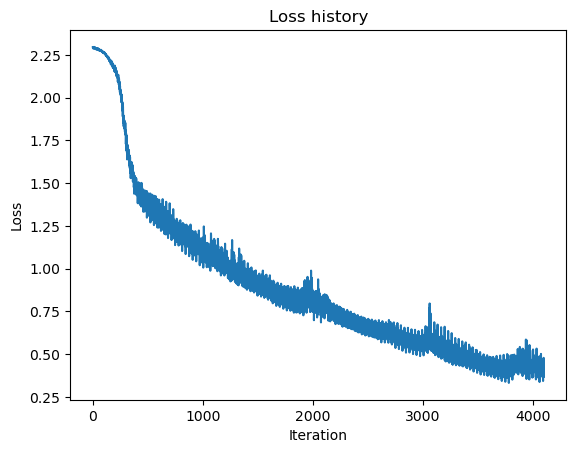

In [10]:
EPOCH_NUM = 128
BATCH_SIZE = 512

# train the model
loss_history = []
for epoch in range(EPOCH_NUM):
    running_loss = 0.0
    for i in tqdm(
            range(0, X_train.shape[0], BATCH_SIZE), 
            # show running loss
            desc=f'Epoch {epoch+1}/{EPOCH_NUM}',
            total=X_train.shape[0]//BATCH_SIZE, 
            # realtime progress bar
            dynamic_ncols=True,
        ):
        # transpose the data to torch tensor
        this_inputs = torch.tensor(X_train[i:i+BATCH_SIZE]).permute(0, 3, 1, 2).float()
        this_labels = torch.tensor(y_train[i:i+BATCH_SIZE]).long()

        optim.zero_grad()

        outputs = net_CNN(this_inputs)
        loss = crit(outputs, this_labels)
        loss.backward()
        optim.step()

        loss_history.append(loss.item())
        running_loss += loss.item()

    print(f'Epoch {epoch+1} loss: {running_loss / (X_train.shape[0] / BATCH_SIZE)}')

# show history
plt.plot(loss_history)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()
plt.close()

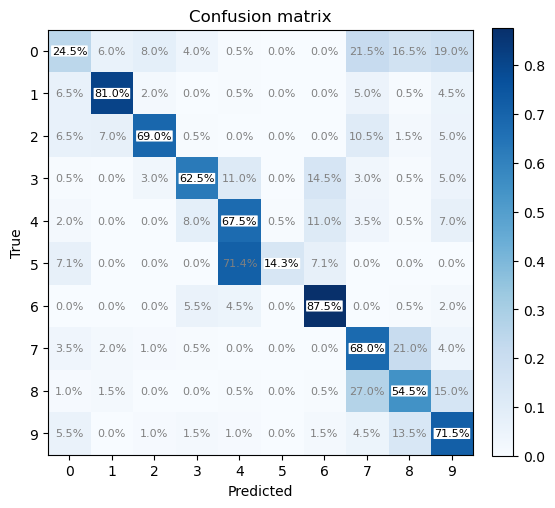

In [13]:
# confusion matrix
from sklearn.metrics import confusion_matrix

with torch.no_grad():
    test_inputs = torch.tensor(X_test).permute(0, 3, 1, 2).float()
    test_labels = torch.tensor(y_test).long()

    outputs = net_CNN(test_inputs)
    _, predicted = torch.max(outputs, 1)

y_pred = predicted.numpy()

confmat = confusion_matrix(y_test, y_pred, labels=range(10), normalize='true')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cax = ax.matshow(confmat, cmap='Blues')
# colorbar lim: 0-1
fig.colorbar(cax, fraction=0.046, pad=0.04, ticks=np.arange(0, 1.1, 0.1))
plt.title('Confusion matrix')
for i in range(10):
    for j in range(10):
        plt.text(j, i, f'{confmat[i, j]*100:.1f}%', ha='center', va='center', color='grey', fontsize=8)
plt.xticks(ticks=range(10), labels=range(10))
plt.yticks(ticks=range(10), labels=range(10))
# accuarcy for each label
for i in range(10):
    # text with border
    plt.text(i, i, f'{confmat[i, i]*100:.1f}%', ha='center', va='center', color='k', fontsize=8, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.05'))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()
plt.close()

In [14]:
# total accuracy
from sklearn.metrics import accuracy_score
print(f'Total accuracy: {accuracy_score(y_test, predicted, normalize=True)}')

Total accuracy: 0.6471885336273429
